In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.0 MB/s eta

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



-

hub://activeloop/nih-chest-xray-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



-

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
class_names = train_ds.findings.info.class_names
num_classes = len(class_names)

class_counts = np.bincount(np.concatenate(train_ds.findings.numpy(aslist = True), axis=0))

for i, class_name in enumerate(class_names):
    print(f"{i+1}. {class_name}: {class_counts[i]}")

1. No Finding: 50500
2. Hernia: 141
3. Emphysema: 1423
4. Nodule: 4708
5. Pneumonia: 876
6. Consolidation: 2852
7. Cardiomegaly: 1707
8. Effusion: 8659
9. Mass: 4034
10. Pleural_Thickening: 2242
11. Atelectasis: 8280
12. Pneumothorax: 2637
13. Fibrosis: 1251
14. Infiltration: 13782
15. Edema: 1378


In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights)
print("Class Weights:", class_weights)

Class Weights: [0.00152181 0.54504381 0.05400645 0.01632353 0.08772965 0.02694642
 0.04502119 0.00887529 0.01905086 0.03427796 0.00928154 0.02914341
 0.0614318  0.0055762  0.05577008]


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device, class_weights):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels, class_weights)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device, class_weights):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels, class_weights)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device, class_weights)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def weighted_binary_cross_entropy(preds, targets, class_weights):
    num_classes = 15
    loss = 0

    class_weights = torch.tensor(class_weights).float().to(preds.device)

    for c in range(num_classes):
        weight_c = class_weights[c]
        loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c], weight=weight_c)
        loss += loss_c

    loss /= num_classes

    return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Sigmoid()
)

for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

for param in model.conv1.parameters():
  param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = weighted_binary_cross_entropy
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.8MB/s]


Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:53<00:00, 40.4MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.0039
Validation phase completed. Average loss: 0.0038
Micro-averaged ROC AUC: 0.8706016358663222
Macro-averaged ROC AUC: 0.6721656948557219
ROC AUC for label 0: 0.6694177026044084
ROC AUC for label 1: 0.761522133456833
ROC AUC for label 2: 0.6231105683915863
ROC AUC for label 3: 0.6014758515252533
ROC AUC for label 4: 0.6621968119344214
ROC AUC for label 5: 0.745952892306035
ROC AUC for label 6: 0.5911988536638877
ROC AUC for label 7: 0.7494299158359334
ROC AUC for label 8: 0.6587118905814108
ROC AUC for label 9: 0.6459726765853401
ROC AUC for label 10: 0.6582952834248624
ROC AUC for label 11: 0.6550235513490107
ROC AUC for label 12: 0.6399856766477083
ROC AUC for label 13: 0.6177151342705254
ROC AUC for label 14: 0.8024764802586135


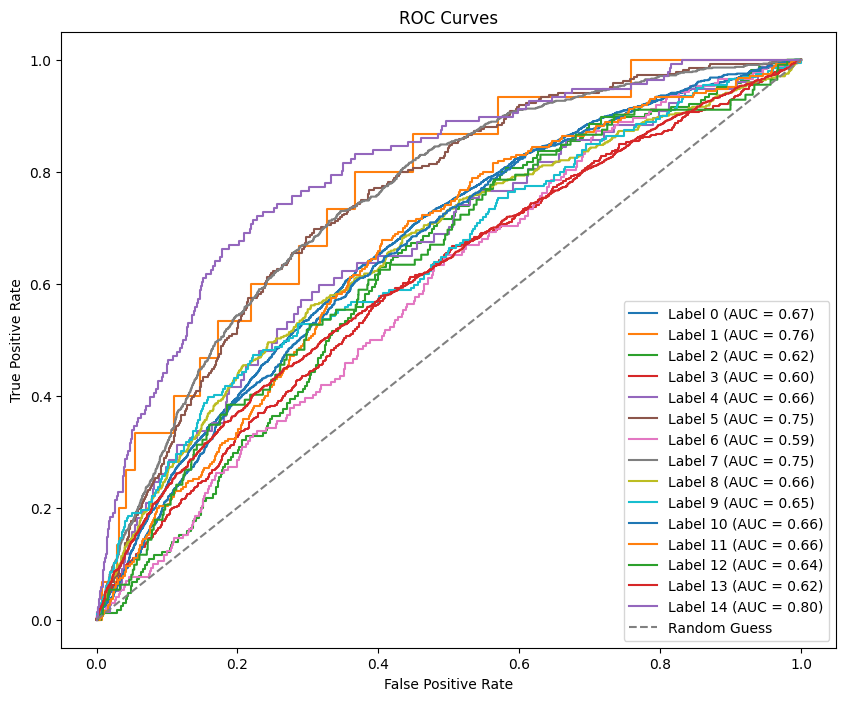

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.0037
Validation phase completed. Average loss: 0.0037
Micro-averaged ROC AUC: 0.8782501101355373
Macro-averaged ROC AUC: 0.6945608613506004
ROC AUC for label 0: 0.688090857527156
ROC AUC for label 1: 0.8324263826174212
ROC AUC for label 2: 0.6616625784176156
ROC AUC for label 3: 0.6054017332505314
ROC AUC for label 4: 0.6619726629056075
ROC AUC for label 5: 0.7578674124094471
ROC AUC for label 6: 0.5940595518867924
ROC AUC for label 7: 0.7714331852396713
ROC AUC for label 8: 0.6432515609086481
ROC AUC for label 9: 0.6884841217800821
ROC AUC for label 10: 0.6725202640816175
ROC AUC for label 11: 0.681566319361595
ROC AUC for label 12: 0.7075986952157912
ROC AUC for label 13: 0.6263144982

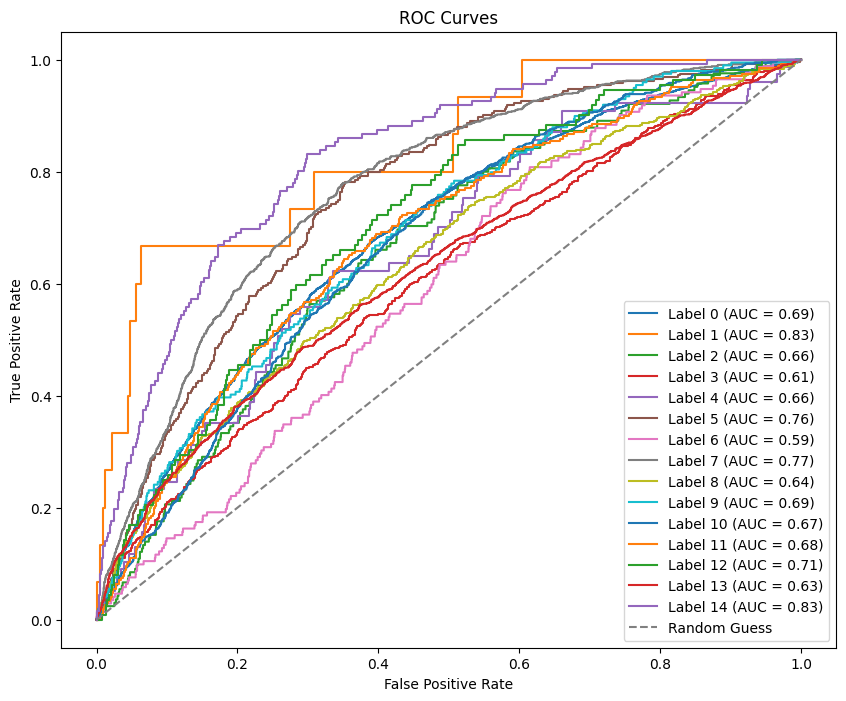

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.0037
Validation phase completed. Average loss: 0.0037
Micro-averaged ROC AUC: 0.8814417279248817
Macro-averaged ROC AUC: 0.7020263865273327
ROC AUC for label 0: 0.6998825827515954
ROC AUC for label 1: 0.8087607579792366
ROC AUC for label 2: 0.6989888278329424
ROC AUC for label 3: 0.6212492723434612
ROC AUC for label 4: 0.6865503010109424
ROC AUC for label 5: 0.7613170057630679
ROC AUC for label 6: 0.6016338032031593
ROC AUC for label 7: 0.7867048679697775
ROC AUC for label 8: 0.6610753941017579
ROC AUC for label 9: 0.6894349899265642
ROC AUC for label 10: 0.6792626044970114
ROC AUC for label 11: 0.6887748879874864
ROC AUC for label 12: 0.7019226748076279
ROC AUC for label 13: 0.62001413

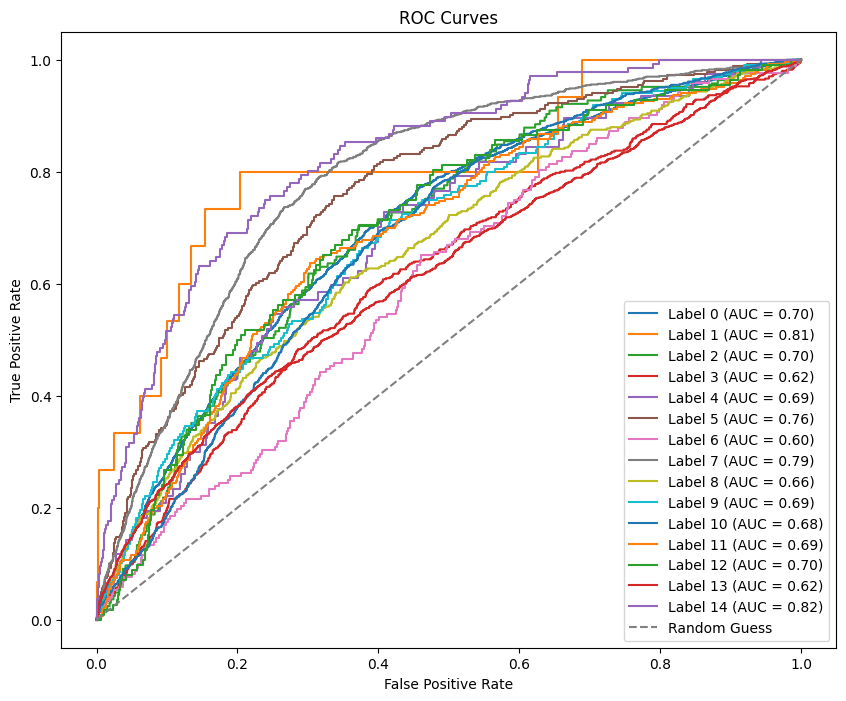

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.0037
Validation phase completed. Average loss: 0.0037
Micro-averaged ROC AUC: 0.8828057069918189
Macro-averaged ROC AUC: 0.7032163258938798
ROC AUC for label 0: 0.7079751298144912
ROC AUC for label 1: 0.7587356721083709
ROC AUC for label 2: 0.678689332347869
ROC AUC for label 3: 0.6349046663596027
ROC AUC for label 4: 0.6992344099049639
ROC AUC for label 5: 0.7611322812592574
ROC AUC for label 6: 0.6198949648968846
ROC AUC for label 7: 0.7944424020422495
ROC AUC for label 8: 0.6753855222955321
ROC AUC for label 9: 0.7129198577769956
ROC AUC for label 10: 0.6792671425016658
ROC AUC for label 11: 0.7115319865319865
ROC AUC for label 12: 0.6673302107728337
ROC AUC for label 13: 0.623868525

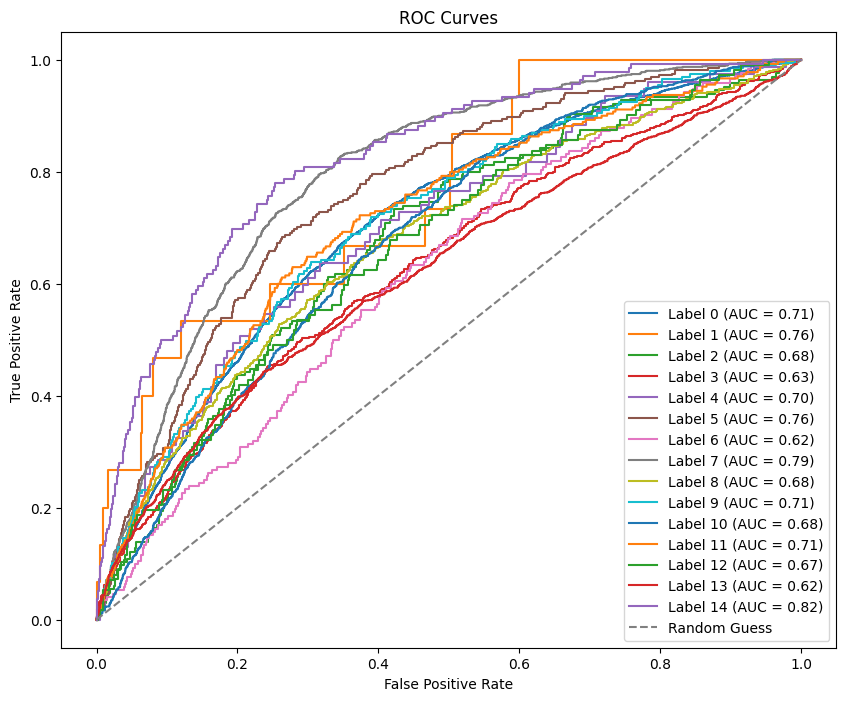

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.0036
Validation phase completed. Average loss: 0.0037
Micro-averaged ROC AUC: 0.8847975658611286
Macro-averaged ROC AUC: 0.704526274631394
ROC AUC for label 0: 0.7065796446050601
ROC AUC for label 1: 0.7737022886032958
ROC AUC for label 2: 0.7208061527255589
ROC AUC for label 3: 0.6406186083196511
ROC AUC for label 4: 0.6490825792283518
ROC AUC for label 5: 0.7521321163116366
ROC AUC for label 6: 0.6242273200965336
ROC AUC for label 7: 0.8015265333938237
ROC AUC for label 8: 0.6542370090333437
ROC AUC for label 9: 0.6835050682253097
ROC AUC for label 10: 0.6944978962566755
ROC AUC for label 11: 0.7110492501568617
ROC AUC for label 12: 0.7056216543994647
ROC AUC for label 13: 0.628620275

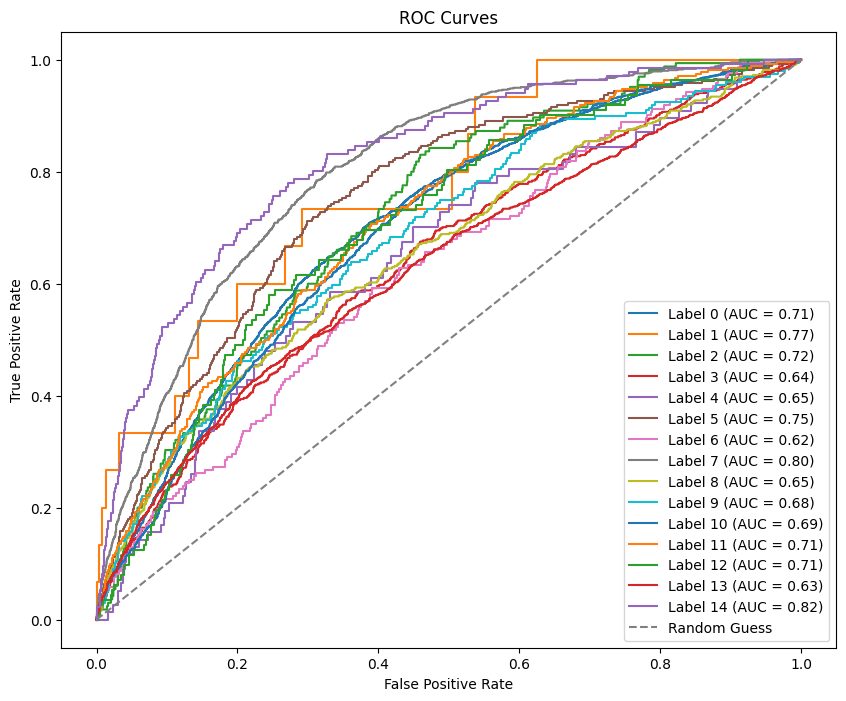

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50_checkpoint_epoch_5.pt


In [ ]:
num_epochs = 5
model_name = "SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_Sigmoid_BCE_Avg_Weighted_Loss_Unbalanced_ResNet50.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device, class_weights)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)